<a href="https://colab.research.google.com/github/tatv047/Miscellaneous-topics/blob/main/Bayesian_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install PyMC
!pip install pymc[all]

In [2]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as at

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
n_samples = 30

w0 = 2.0
w1 = 4.5

x = np.sort(np.random.rand(n_samples))
y = w0 + w1 * x + np.random.randn(n_samples)

In [4]:
model = pm.Model()

with model:
  w0_hat = pm.Normal("w0",mu = 0,sigma = 10)
  w1_hat = pm.Normal("w1",mu = 0,sigma = 10)
  sigma = pm.HalfNormal("sigma",sigma = 1)

  mu = w0_hat + w1_hat*x

  y_hat = pm.Normal("y_hat",mu = mu,sigma = sigma,observed = y)


In [5]:
with model:
  sample = pm.sample()

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w0'}>, <Axes: title={'center': 'w0'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>]],
      dtype=object)

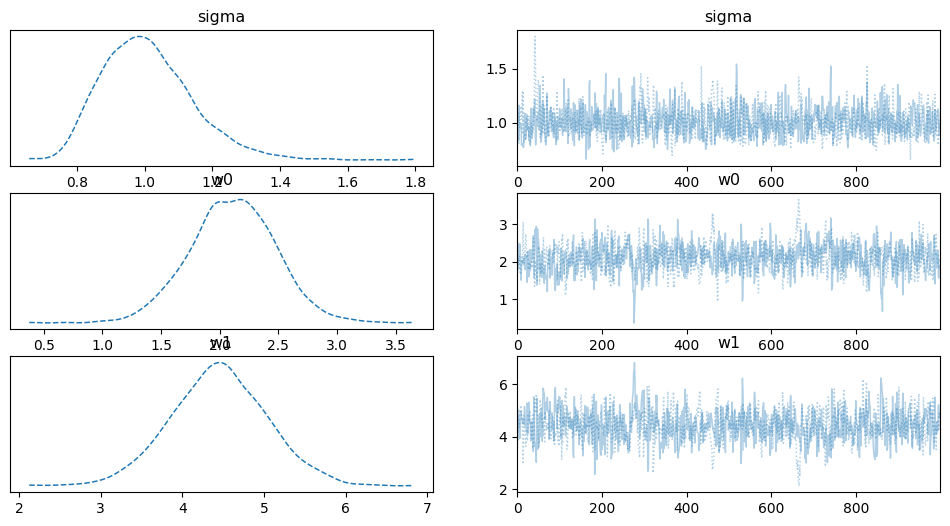

In [6]:
az.plot_trace(sample,combined = True)

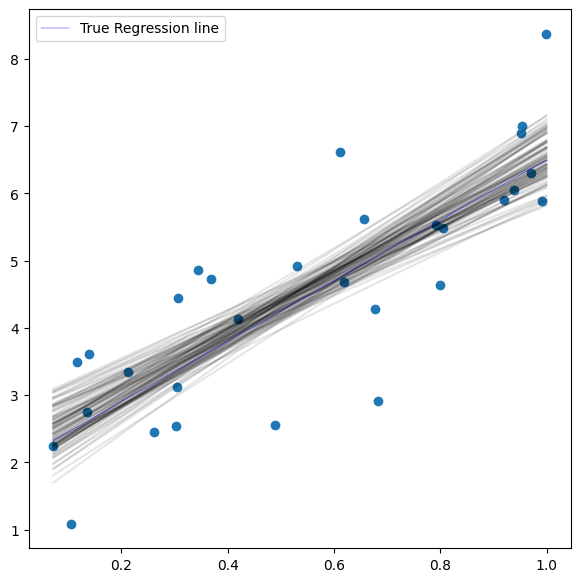

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(x, y)

# extract intercept(w0) draws from PyMC
w0_ = sample.posterior.w0.to_numpy()[0]
w1_ = sample.posterior.w1.to_numpy()[0]

sample_indexes = np.random.randint(len(w0_), size=100)

for i in sample_indexes:
    y_line = w0_[i] + w1_[i] * x
    ax.plot(x, y_line, c='black', alpha=0.1)

true_y = w0 + w1 * x
ax.plot(x, true_y, label="True Regression line", lw=.3, c='blue')
ax.legend(loc=0)
plt.show()

## Student Performance Dataset

In [8]:
df = pd.read_csv('/content/sample_data/Student_Performance.csv')
df.head(3)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0


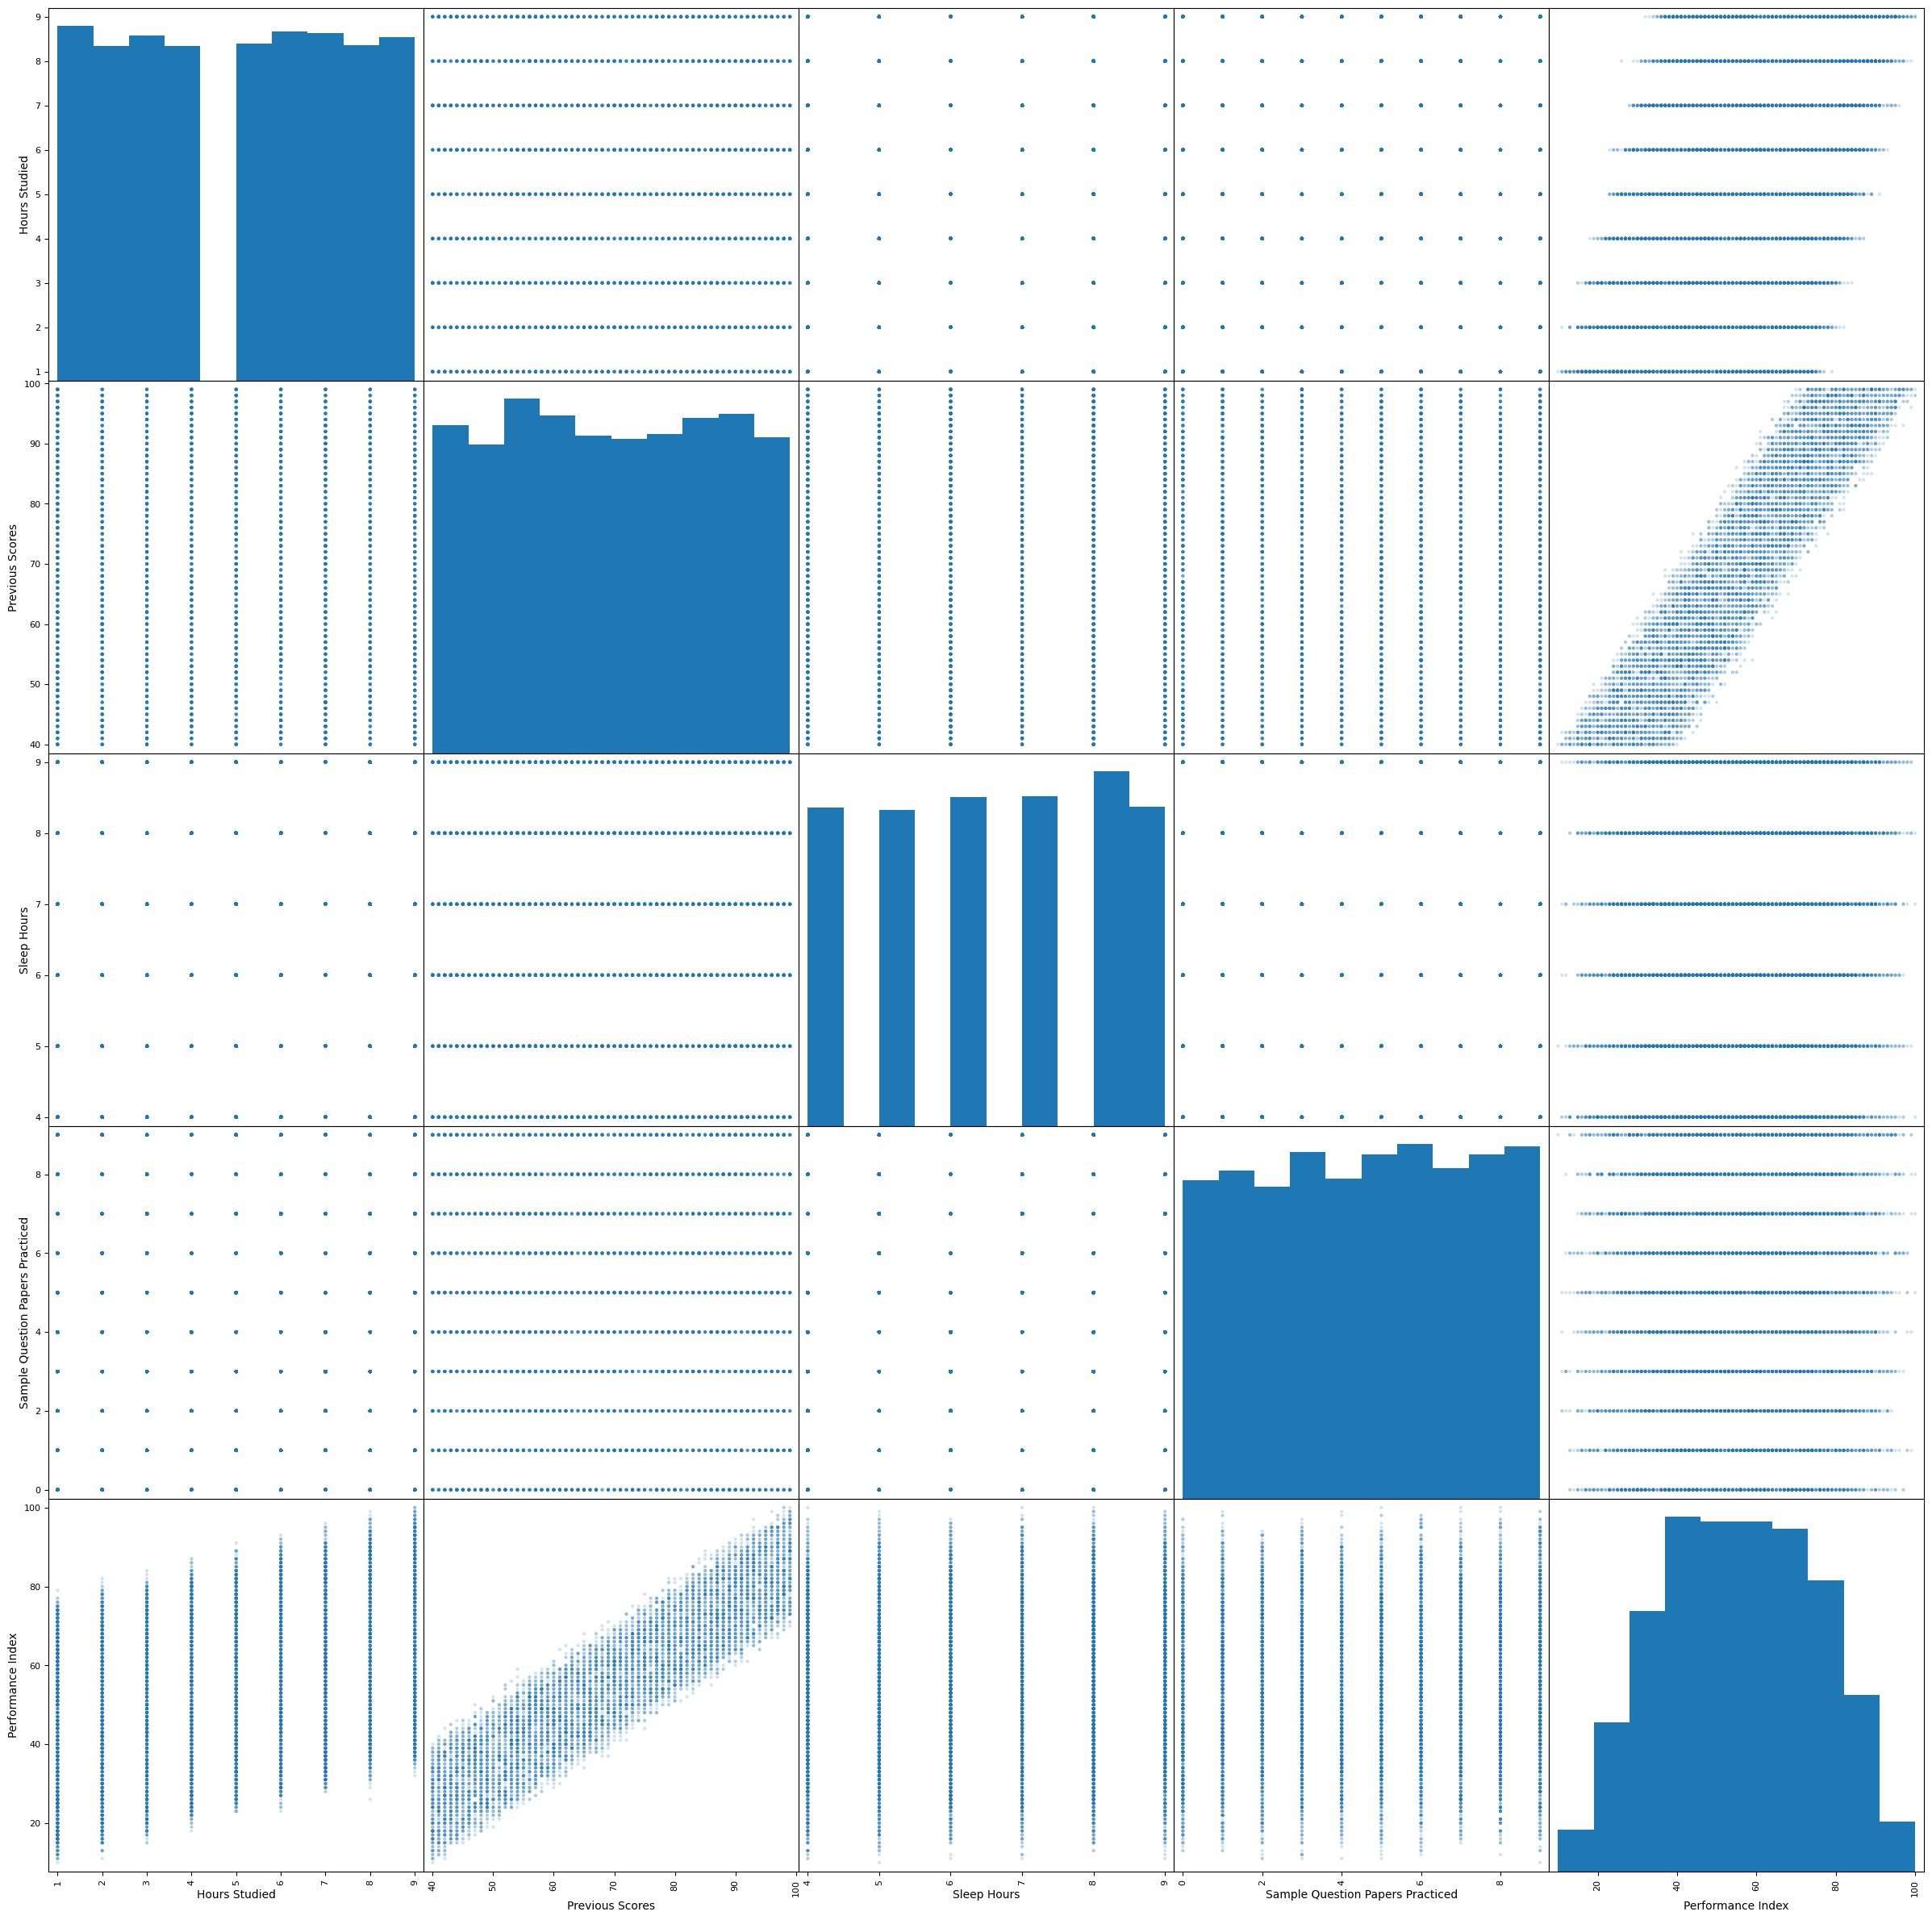

In [9]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(30, 30));

In [10]:
le = LabelEncoder()

df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])

In [11]:
df = df[~df.duplicated()]
df = df.dropna().astype(float)

columns = df.columns.values[:-1]

In [12]:

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X = X.astype(float)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('train and test size')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train and test size
(8885, 5) (988, 5) (8885,) (988,)


In [13]:
test_score_bayesian = pm.Model(coords={"predictors": columns})

with test_score_bayesian:
    # posterior variance
    sigma = pm.HalfNormal("sigma", 25)

    # beta
    beta = pm.Normal("beta", 0, 10, dims="predictors")
    beta0 = pm.Normal("beta0", 0, 10)

    mu = beta0 + at.dot(X_train, beta)

    y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_train)


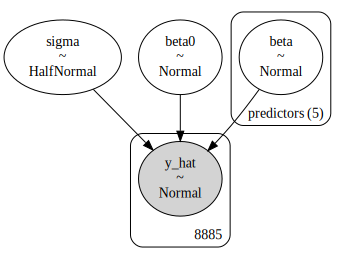

In [14]:

pm.model_to_graphviz(test_score_bayesian)

In [15]:
with test_score_bayesian:
    sample = pm.sample()


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

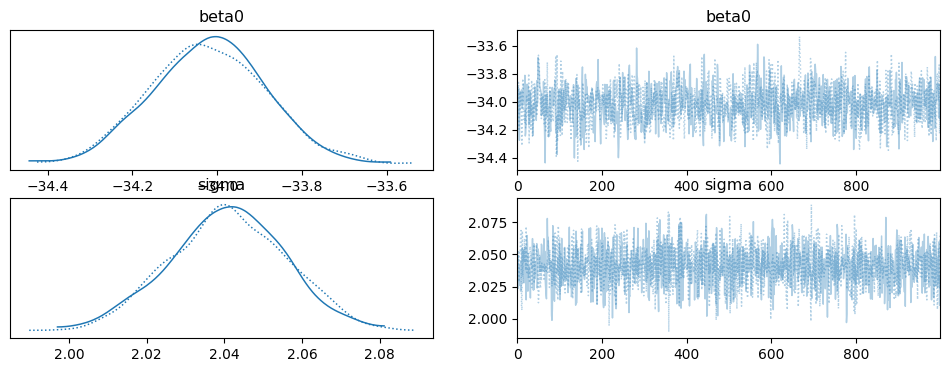

In [16]:
az.plot_trace(sample, var_names=["beta0", "sigma"])


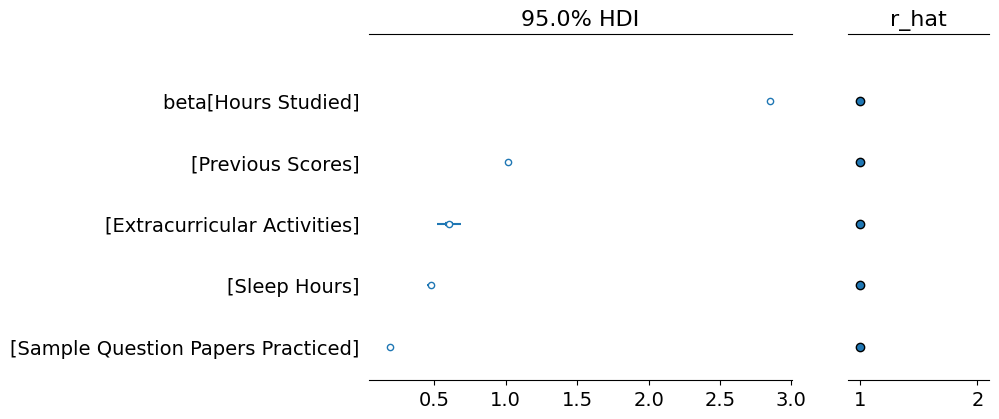

In [17]:
az.plot_forest(sample, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [18]:
az.summary(sample)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Hours Studied],2.852,0.008,2.837,2.868,0.000,0.000,2010.0,1376.0,1.0
beta[Previous Scores],1.018,0.001,1.016,1.021,0.000,0.000,1813.0,1544.0,1.0
beta[Extracurricular Activities],0.602,0.043,0.526,0.686,0.001,0.001,1944.0,1217.0,1.0
beta[Sleep Hours],0.475,0.013,0.451,0.500,0.000,0.000,1593.0,1333.0,1.0
beta[Sample Question Papers Practiced],0.192,0.007,0.180,0.206,0.000,0.000,2051.0,1382.0,1.0
beta0,-34.020,0.133,-34.266,-33.775,0.004,0.003,1241.0,1264.0,1.0
sigma,2.041,0.015,2.014,2.071,0.000,0.000,2363.0,1132.0,1.0
